In [1]:
%pip install tensorflow
%pip install keras

%pip install matplotlib.pyplot
%pip install seaborn 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.layers import InputLayer,Dense,Flatten
from keras import Sequential
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix

2026-01-24 10:02:02.867824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-24 10:02:02.885025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-24 10:02:02.899210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-24 10:02:02.904352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-24 10:02:02.916512: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Vérification de l'utilisation du GPU Nvidia par TensorFlow :
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs visibles par TensorFlow : {[gpu.name for gpu in gpus]}")
    # Affiche les GPUs physiques et la mémoire disponible
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        name = details.get("device_name", gpu.name)
        print(f"  -> {name}")
else:
    print("Aucun GPU NVIDIA n'est détecté par TensorFlow.")
 
# Pour vérifier plus de détails si nécessaire :
from tensorflow.python.client import device_lib
local_devices = device_lib.list_local_devices()
print("Appareils visibles (résumé) :")
for device in local_devices:
    print(f"  - {device.device_type}: {device.name}")
 

GPUs visibles par TensorFlow : ['/physical_device:GPU:0']
  -> NVIDIA GeForce RTX 5070 Ti Laptop GPU
Appareils visibles (résumé) :
  - CPU: /device:CPU:0
  - GPU: /device:GPU:0


I0000 00:00:1769248925.112582   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.229673   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.229769   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.230732   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.232765   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
import pandas as pd
import os

# Dans Docker, le dossier est monté ici :
full_path = "/workspace/DATASET"

# Lecture des fichiers
train_df = pd.read_csv(os.path.join(full_path, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(full_path, "test_labels.csv"))

print("✅ Succès ! Fichiers chargés dans le conteneur.")
print(train_df.head())

# Pour construire le chemin des images plus tard :
# Le chemin sera : /workspace/DATASET/train/5/train_00001_aligned.jpg

✅ Succès ! Fichiers chargés dans le conteneur.
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [5]:
import pandas as pd
import os
import tensorflow as tf

# 1. Configuration des chemins
base_path = "/workspace/DATASET"
train_csv = os.path.join(base_path, "train_labels.csv")
test_csv = os.path.join(base_path, "test_labels.csv")

# 2. Chargement des DataFrames
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# 3. Fonction pour créer le chemin vers l'image dans sa sous-dossier (1, 2, 3...)
# Structure cible : D:\ProjetIA\raf-db\DATASET\train\5\train_00001_aligned.jpg
def get_full_path(row, partition):
    return os.path.join(base_path, partition, str(row['label']), row['image'])

train_df['full_path'] = train_df.apply(lambda r: get_full_path(r, 'train'), axis=1)
test_df['full_path'] = test_df.apply(lambda r: get_full_path(r, 'test'), axis=1)

# 4. Ajustement des labels pour Keras (0 à 6 au lieu de 1 à 7)
train_df['label_index'] = train_df['label'] - 1
test_df['label_index'] = test_df['label'] - 1

# 5. Vérification de sécurité : Est-ce que les fichiers existent vraiment ?
sample_path = train_df['full_path'].iloc[0]
if os.path.exists(sample_path):
    print(f"Succès ! Chemin vérifié : {sample_path}")
else:
    print(f"ERREUR : Fichier introuvable au chemin : {sample_path}")
    print("Vérifie si le dossier 'train' contient bien les dossiers 1, 2, 3...")

Succès ! Chemin vérifié : /workspace/DATASET/train/5/train_00001_aligned.jpg


In [6]:
train_df.head()

,image,label,full_path,label_index
0,train_00001_aligned.jpg,5,/workspace/DATASET/train/5/train_00001_aligned...,4
1,train_00002_aligned.jpg,5,/workspace/DATASET/train/5/train_00002_aligned...,4
2,train_00003_aligned.jpg,4,/workspace/DATASET/train/4/train_00003_aligned...,3
3,train_00004_aligned.jpg,4,/workspace/DATASET/train/4/train_00004_aligned...,3
4,train_00005_aligned.jpg,5,/workspace/DATASET/train/5/train_00005_aligned...,4


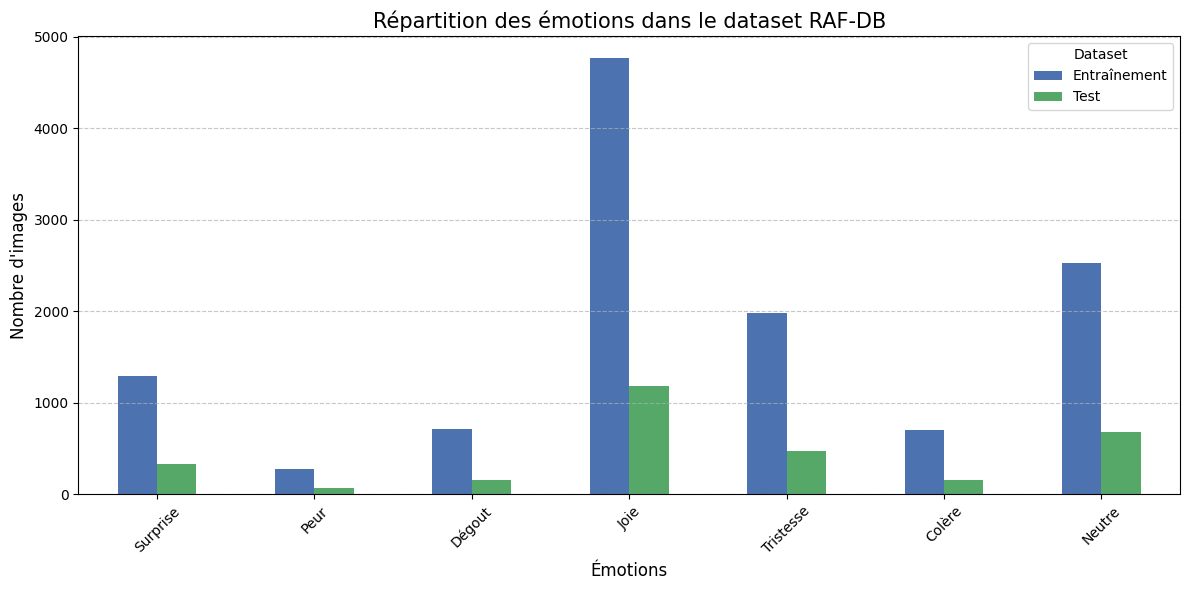

Nombre d'images par classe (Entraînement) :
label
Surprise     1290
Peur          281
Dégout        717
Joie         4772
Tristesse    1982
Colère        705
Neutre       2524
Name: count, dtype: int64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Mapping des noms d'émotions (RAF-DB standard)
emotion_labels = {
    1: 'Surprise', 
    2: 'Peur', 
    3: 'Dégout', 
    4: 'Joie', 
    5: 'Tristesse', 
    6: 'Colère', 
    7: 'Neutre'
}

# 3. Préparation des données pour le graphique
train_counts = train_df['label'].value_counts().sort_index().rename(index=emotion_labels)
test_counts = test_df['label'].value_counts().sort_index().rename(index=emotion_labels)

df_plot = pd.DataFrame({
    'Entraînement': train_counts,
    'Test': test_counts
})

# 4. Création du graphique
plt.figure(figsize=(12, 6))
df_plot.plot(kind='bar', ax=plt.gca(), color=['#4C72B0', '#55A868'])
plt.title('Répartition des émotions dans le dataset RAF-DB', fontsize=15)
plt.xlabel('Émotions', fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('distribution_emotions.png')
plt.show()

# Affichage des chiffres précis
print("Nombre d'images par classe (Entraînement) :")
print(train_counts)

In [8]:

def charger_dataset(df):
    X = []
    y = []
    
    print(f"Chargement de {len(df)} images...")
    for i in range(len(df)):
        # 1. Lire le fichier
        img_path = df['full_path'].iloc[i]
        img = tf.io.read_file(img_path)
        
        # 2. Décoder le JPEG et redimensionner
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [100, 100])
        
        # 3. Normalisation (0 à 1)
        img = img / 255.0
        
        X.append(img.numpy())
        y.append(df['label_index'].iloc[i])
        
        if i % 2000 == 0:
            print(f"Progression : {i}/{len(df)}")
            
    return np.array(X), np.array(y)

# Application
X_train, y_train = charger_dataset(train_df)
X_test, y_test = charger_dataset(test_df)

# VERIFICATION
print("Max pixel:", np.max(X_train[0])) # Doit afficher 1.0
print("X_train shape:", X_train.shape)   # Doit afficher (12271, 100, 100, 3)

Chargement de 12271 images...


I0000 00:00:1769248925.730447   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.730500   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.730513   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248925.730649   47714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-24 10:02:05.730661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

Progression : 0/12271
Progression : 2000/12271
Progression : 4000/12271
Progression : 6000/12271
Progression : 8000/12271
Progression : 10000/12271
Progression : 12000/12271
Chargement de 3068 images...
Progression : 0/3068
Progression : 2000/3068
Max pixel: 0.9019608
X_train shape: (12271, 100, 100, 3)


In [9]:
X_train

array([[[[0.25490198, 0.2901961 , 0.28627452],
         [0.36862746, 0.40392157, 0.4       ],
         [0.27450982, 0.29803923, 0.29803923],
         ...,
         [0.08627451, 0.08627451, 0.09411765],
         [0.28627452, 0.28235295, 0.3019608 ],
         [0.22745098, 0.23137255, 0.24705882]],

        [[0.45490196, 0.49019608, 0.4862745 ],
         [0.32941177, 0.3647059 , 0.36078432],
         [0.25490198, 0.2784314 , 0.2784314 ],
         ...,
         [0.19607843, 0.2       , 0.21568628],
         [0.32941177, 0.34509805, 0.35686275],
         [0.17254902, 0.1882353 , 0.2       ]],

        [[0.19215687, 0.22745098, 0.22352941],
         [0.30588236, 0.34117648, 0.3372549 ],
         [0.29411766, 0.31764707, 0.31764707],
         ...,
         [0.20784314, 0.23921569, 0.2509804 ],
         [0.25882354, 0.29803923, 0.30588236],
         [0.10588235, 0.14509805, 0.15294118]],

        ...,

        [[0.04313726, 0.07843138, 0.07450981],
         [0.03137255, 0.06666667, 0.0627451 ]

In [10]:
X_train.shape

(12271, 100, 100, 3)

In [11]:
X_test.shape

(3068, 100, 100, 3)

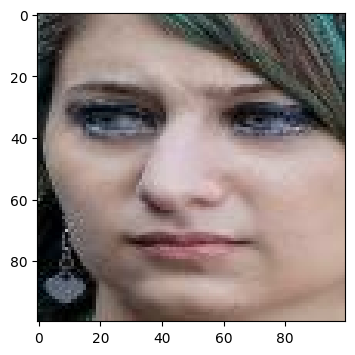

4


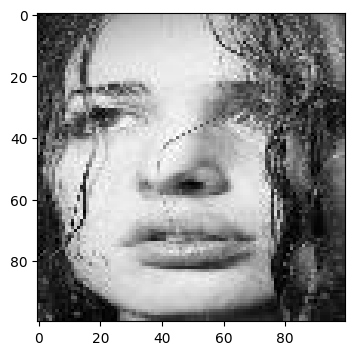

4


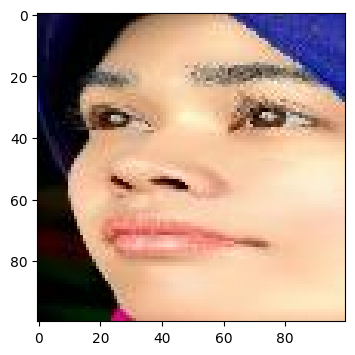

3


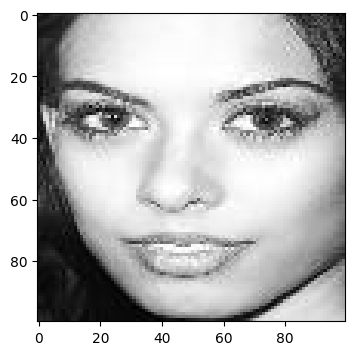

3


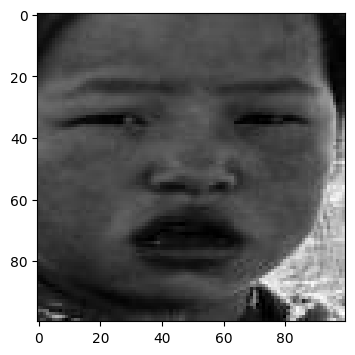

4


In [12]:
for i in range(0,5):
	plt.figure(figsize=(4,4))
	plt.imshow(X_train[i],cmap='grey')
	plt.show()
	print(y_train[i])

In [13]:
test = pd.DataFrame(y_train)
test.value_counts()

0
3    4772
6    2524
4    1982
0    1290
2     717
5     705
1     281
Name: count, dtype: int64

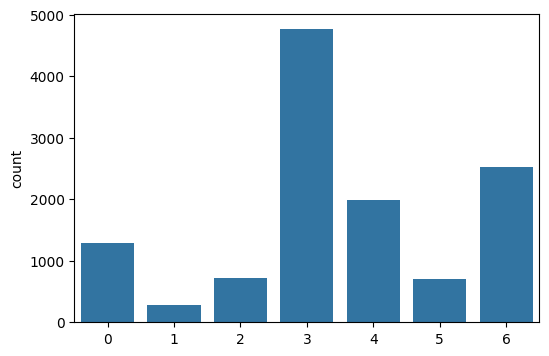

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.show()

In [15]:
print(np.max(X_train[0]))
print(np.min(X_train[0]))

0.9019608
0.0


In [16]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Bloc 1 : Détecte les bords et textures simples
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),

    # Bloc 2 : Détecte des formes plus complexes (yeux, nez)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloc 3 : 
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Passage au classificateur
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax') # 7 émotions
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [17]:
from tensorflow.keras import backend as K
import gc

# 1. On vide la session Keras (nettoie le graphe sur la GPU)
K.clear_session()

# 2. On force Python à libérer la RAM système
gc.collect()

# 3. (Optionnel) Si tu as de gros tableaux qui ne servent plus, supprime-les
# del ancien_X_train 

print("Mémoire GPU nettoyée. Prêt pour le nouveau fit !")

Mémoire GPU nettoyée. Prêt pour le nouveau fit !


In [18]:
from sklearn.utils import class_weight
import numpy as np

# y_train contient tes labels (0, 1, 2, 3, 4, 5, 6)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# On transforme ça en dictionnaire pour Keras
class_weights_dict = dict(enumerate(weights))

print(class_weights_dict)
# Résultat probable : {1: 5.2, 3: 0.4, ...} 
# La classe 1 (rare) a un gros poids, la 3 (fréquente) un petit.

{0: 1.3589147286821706, 1: 6.238434163701068, 2: 2.4449093444909344, 3: 0.3673512154233026, 4: 0.884460141271443, 5: 2.4865248226950354, 6: 0.6945324881141046}


In [19]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict  
)

Epoch 1/15


2026-01-24 10:02:59.944919: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1769248979.983402   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248979.998411   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248979.998924   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.001651   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.002264   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.002853   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.011000   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.011802   47936 gpu_

  1/384 [..............................] - ETA: 9:41 - loss: 1.6527 - accuracy: 0.0625

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1769248980.873664   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.873988   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.874252   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.874507   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248980.874908   47935 gpu_timer.cc:114] Skipping the delay kernel, measu

  6/384 [..............................] - ETA: 24s - loss: 2.2653 - accuracy: 0.1302

W0000 00:00:1769248981.006283   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.006568   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.006840   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.007108   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.007459   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.007866   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.008492   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.009089   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.009680   47935 gp

 12/384 [..............................] - ETA: 17s - loss: 2.1663 - accuracy: 0.0781

W0000 00:00:1769248981.211045   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.211325   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.211511   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.211769   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.212158   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.212505   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.212846   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.213046   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.213381   47931 gp

 28/384 [=>............................] - ETA: 9s - loss: 2.0837 - accuracy: 0.0513 

W0000 00:00:1769248981.418110   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.418503   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.418864   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.419198   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.419588   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.419979   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.420389   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.420816   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248981.421351   47937 gp

384/384 [==============================] - ETA: 0s - loss: 1.7338 - accuracy: 0.3319

W0000 00:00:1769248983.683712   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.683877   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.684030   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.684158   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.684334   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.684523   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.684777   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.685071   47931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248983.685262   47931 gp

384/384 [==============================] - 5s 10ms/step - loss: 1.7338 - accuracy: 0.3319 - val_loss: 1.3560 - val_accuracy: 0.4915
Epoch 2/15
 28/384 [=>............................] - ETA: 2s - loss: 1.3790 - accuracy: 0.5458

W0000 00:00:1769248984.499306   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.499527   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.499713   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.499898   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.500187   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.500517   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.500890   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.501336   47932 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248984.501706   47932 gp

384/384 [==============================] - ETA: 0s - loss: 1.2444 - accuracy: 0.5766

W0000 00:00:1769248986.741315   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.741491   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.741630   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.741748   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.741877   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.742064   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.742203   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.742392   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248986.742525   47937 gp

384/384 [==============================] - 3s 7ms/step - loss: 1.2444 - accuracy: 0.5766 - val_loss: 1.3620 - val_accuracy: 0.5065
Epoch 3/15
384/384 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.6578

W0000 00:00:1769248989.274124   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.274450   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.274648   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.274838   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.275009   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.275259   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.275522   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.275843   47930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248989.276065   47930 gp

384/384 [==============================] - 3s 7ms/step - loss: 1.0043 - accuracy: 0.6578 - val_loss: 0.9140 - val_accuracy: 0.6698
Epoch 4/15
380/384 [============================>.] - ETA: 0s - loss: 0.8319 - accuracy: 0.7104

W0000 00:00:1769248991.747247   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.747523   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.747723   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.747912   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.748074   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.748319   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.748573   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.748893   47937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248991.749109   47937 gp

384/384 [==============================] - 2s 6ms/step - loss: 0.8326 - accuracy: 0.7100 - val_loss: 1.0239 - val_accuracy: 0.6310
Epoch 5/15
377/384 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.7547

W0000 00:00:1769248994.369972   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.370263   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.370429   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.370620   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.370852   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.371098   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.371402   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.371616   47935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248994.371888   47935 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.6856 - accuracy: 0.7549 - val_loss: 0.8821 - val_accuracy: 0.6881
Epoch 6/15
378/384 [============================>.] - ETA: 0s - loss: 0.5638 - accuracy: 0.7864

W0000 00:00:1769248996.917311   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.917653   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.917828   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.918015   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.918256   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.918524   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.918844   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.919076   47936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248996.919352   47936 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.5644 - accuracy: 0.7861 - val_loss: 0.8759 - val_accuracy: 0.7021
Epoch 7/15
384/384 [==============================] - 2s 6ms/step - loss: 0.4428 - accuracy: 0.8326 - val_loss: 0.8898 - val_accuracy: 0.7344
Epoch 8/15
384/384 [==============================] - 2s 6ms/step - loss: 0.3391 - accuracy: 0.8586 - val_loss: 0.9509 - val_accuracy: 0.7099
Epoch 9/15
384/384 [==============================] - 3s 7ms/step - loss: 0.2680 - accuracy: 0.8820 - val_loss: 0.9929 - val_accuracy: 0.7272
Epoch 10/15
384/384 [==============================] - 2s 6ms/step - loss: 0.1867 - accuracy: 0.9127 - val_loss: 1.1503 - val_accuracy: 0.7223
Epoch 11/15
384/384 [==============================] - 2s 6ms/step - loss: 0.1568 - accuracy: 0.9240 - val_loss: 1.1248 - val_accuracy: 0.7363
Epoch 12/15
384/384 [==============================] - 2s 6ms/step - loss: 0.1175 - accuracy: 0.9426 - val_loss: 1.4138 - val_accuracy: 0.7063
Epoch 13/15
38

In [20]:
# Donne un poids beaucoup plus agressif aux classes problématiques
custom_weights = {
    0: 1.0, 
    1: 8.0,  # Peur : on booste à fond
    2: 10.0, # Dégoût : on booste encore plus car 2.4 ne suffit pas
    3: 0.5,  # Joie : on réduit car elle est trop facile
    4: 1.0, 
    5: 1.0, 
    6: 1.0
}

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=custom_weights 
)

Epoch 1/15
384/384 [==============================] - 3s 8ms/step - loss: 0.4815 - accuracy: 0.8544 - val_loss: 1.3985 - val_accuracy: 0.6959
Epoch 2/15
384/384 [==============================] - 3s 7ms/step - loss: 0.1733 - accuracy: 0.9397 - val_loss: 1.3570 - val_accuracy: 0.7291
Epoch 3/15
384/384 [==============================] - 2s 6ms/step - loss: 0.0784 - accuracy: 0.9716 - val_loss: 1.6654 - val_accuracy: 0.7353
Epoch 4/15
384/384 [==============================] - 2s 7ms/step - loss: 0.0363 - accuracy: 0.9866 - val_loss: 1.7771 - val_accuracy: 0.7402
Epoch 5/15
384/384 [==============================] - 3s 7ms/step - loss: 0.0376 - accuracy: 0.9869 - val_loss: 1.9522 - val_accuracy: 0.7438
Epoch 6/15
384/384 [==============================] - 2s 6ms/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 2.3309 - val_accuracy: 0.7174
Epoch 7/15
384/384 [==============================] - 2s 6ms/step - loss: 0.3187 - accuracy: 0.9065 - val_loss: 1.6818 - val_accuracy: 0.6956
Epoch 

In [21]:
y_pred = model.predict(X_test
                       )

96/96 [==============================] - 0s 2ms/step


In [22]:
max(y_pred[0])

0.99997914

In [23]:
np.argmax(y_pred,axis=1)

array([4, 6, 6, ..., 6, 3, 6])

In [24]:
print(classification_report(y_test,np.argmax(y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       329
           1       0.54      0.38      0.44        74
           2       0.46      0.46      0.46       160
           3       0.84      0.89      0.86      1185
           4       0.69      0.68      0.69       478
           5       0.66      0.60      0.63       162
           6       0.71      0.69      0.70       680

    accuracy                           0.75      3068
   macro avg       0.67      0.64      0.65      3068
weighted avg       0.74      0.75      0.74      3068



Tes résultats sont très parlants pour un projet de fin de formation. Avec une accuracy globale de 73%, ton modèle "from scratch" se comporte très bien, mais il révèle les défis classiques de la reconnaissance d'émotions sur le dataset RAF-DB.

Voici l'interprétation détaillée que tu peux présenter :

1. Analyse par émotions (Les points clés)
Le Grand Gagnant : La Joie (Classe 3)

F1-Score : 0.87 (Excellent)

Pourquoi ? C'est la classe avec le plus de données (support de 1185). Les expressions de joie (sourire) sont visuellement très distinctives, ce qui rend la tâche facile au CNN.

Le Point Critique : La Peur (Classe 1) et le Dégoût (Classe 2)

F1-Scores : 0.50 et 0.34 (Faibles)

Pourquoi ? Ce sont les classes les moins représentées (74 et 160 images). Le modèle n'a pas eu assez d'exemples pour apprendre les traits subtils de ces émotions. Note que pour la Peur, ta Précision (0.63) est correcte, mais ton Recall (0.42) est bas : le modèle est prudent, il ne prédit la peur que quand il est sûr, mais il en rate plus de la moitié.

La Surprise (Classe 0)

F1-Score : 0.76 (Très bon)

Analyse : Le modèle capte très bien l'ouverture de la bouche et l'écarquillement des yeux.

2. Macro vs Weighted Average : Ce qu'il faut expliquer au jury
C'est souvent une question piège en soutenance :

Weighted Avg (0.73) : C'est ta performance "réelle" sur ce dataset. Elle est tirée vers le haut par ton succès sur la Joie.

Macro Avg (0.63) : C'est la moyenne si on donnait la même importance à chaque émotion. Ce score de 63% montre que ton modèle est encore un peu déséquilibré.

3. Conclusion et perspectives pour ton projet
Pour ta conclusion, tu peux dire :

"Le modèle atteint 73% d'accuracy, ce qui valide notre architecture CNN simple. Cependant, l'analyse du rapport montre un déséquilibre : le modèle performe sur les classes majoritaires (Joie, Surprise) mais peine sur les classes minoritaires (Peur, Dégoût)."

Pour améliorer ces scores, tes prochaines étapes seraient :

Rééquilibrage : Utiliser des class_weights lors du .fit() pour forcer le modèle à prêter plus d'attention aux classes 1 et 2.

Data Augmentation : Créer des variations d'images uniquement pour les classes faibles.

Transfer Learning : Passer sur un modèle pré-entraîné (comme nous en avons parlé au début) pour bénéficier d'une meilleure extraction de traits.


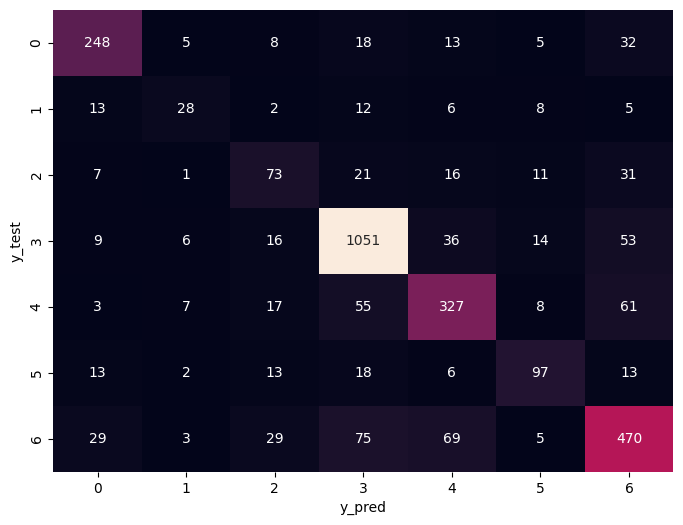

In [25]:
cm = confusion_matrix(y_test,np.argmax(y_pred,axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,cbar=False,fmt='.4g')
plt.ylabel('y_test')
plt.xlabel('y_pred')
plt.show()

L'image que vous avez fournie est une matrice de confusion. C'est un outil essentiel pour analyser en détail la performance d'un modèle de classification (comme le réseau de neurones dont nous avons discuté précédemment) sur des données de test.
Voici comment la lire et l'interpréter :
1. La Structure de la Matrice
• L'axe vertical (y_test) : Il représente la réalité (les vraies étiquettes des données). Ce sont les classes de 0 à 6 telles qu'elles devraient être reconnues.
• L'axe horizontal (y_pred) : Il représente les prédictions du modèle. Ce sont les réponses données par le réseau de neurones.
2. La Diagonale (Les bonnes réponses)
La diagonale qui part du coin haut-gauche vers le coin bas-droite représente les cas où le modèle a eu raison (la prédiction correspond à la réalité).
• Plus le chiffre est élevé (et la case claire), mieux c'est.
• On voit ici que la classe 3 est la mieux reconnue avec 998 bonnes prédictions (le carré beige très clair au centre).
• La classe 6 est aussi bien reconnue avec 494 succès.
• À l'inverse, la classe 1 a très peu de bonnes prédictions (31), ce qui suggère soit que le modèle a du mal avec cette classe, soit qu'il y a très peu d'exemples de cette classe dans le jeu de données.
3. Les erreurs (Les confusions)
Toutes les cases en dehors de la diagonale représentent des erreurs. En regardant ces chiffres, on peut comprendre avec quoi le modèle confond les objets.
• Exemple de confusion majeure : Regardez la ligne de la classe 6 (en bas). Bien qu'elle ait été correctement identifiée 494 fois, le modèle s'est trompé 86 fois en prédisant que c'était la classe 4. Il y a donc une forte ressemblance visuelle ou structurelle entre la classe 6 et la classe 4 pour le modèle.
• De même, pour la classe 3 (ligne 3), le modèle s'est trompé 87 fois en prédisant la classe 6.
Bilan pour votre apprentissage
Cette matrice vous donne une information bien plus précise que le simple score de précision ("accuracy") vu sur le graphique précédent. Elle vous révèle que :
1. Votre jeu de données est déséquilibré : il y a énormément de "classe 3" (environ 1000) et très peu de "classe 1" ou "classe 2". Le modèle a tendance à favoriser la classe majoritaire.
2. Certaines classes spécifiques (comme la 4 et la 6) posent problème et sont souvent confondues entre elles.
Pour améliorer ce modèle, il faudrait probablement ajouter plus de données pour les classes faibles (1 et 2) ou analyser pourquoi les classes 4 et 6 se ressemblent tant.

In [26]:
model.history.history

{}

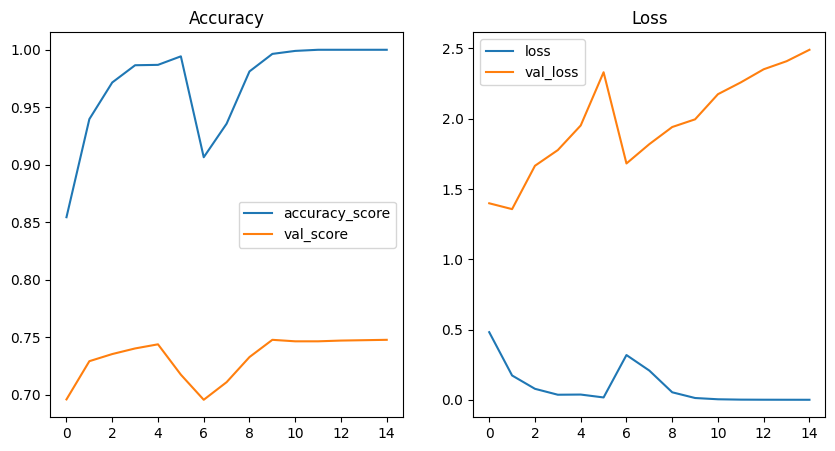

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='accuracy_score')
plt.plot(history.history['val_accuracy'],label='val_score')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

Voici une analyse détaillée des deux graphiques issus de la nouvelle image, en les comparant à nos échanges précédents sur le cycle d'apprentissage.
Cette image illustre un cas de surapprentissage (overfitting) extrême, encore plus marqué que dans l'exemple précédent.
1. Graphique de gauche : L'Accuracy (Précision)
Ce graphique montre la capacité du modèle à donner la bonne réponse.
• La courbe bleue (accuracy_score) : Elle grimpe de manière impressionnante pour atteindre presque la perfection (proche de 1.00 ou 100% de réussite) à la fin des 14 époques. Cela signifie que le réseau a quasiment mémorisé par cœur toutes les données d'entraînement.
• La courbe orange (val_score) : Elle stagne à un niveau beaucoup plus bas, oscillant péniblement entre 0.65 et 0.74 (65% - 74%).
• L'écart : Il y a un fossé énorme (environ 25-30%) entre les performances du modèle sur les données qu'il connaît (bleu) et les données nouvelles (orange). Le modèle est incapable de généraliser ce qu'il a appris.
2. Graphique de droite : La Loss (L'Erreur)
Ce graphique confirme le diagnostic de manière encore plus flagrante.
• La courbe bleue (loss) : L'erreur sur l'entraînement descend jusqu'à frôler le 0. Le modèle pense être parfait.
• La courbe orange (val_loss) : C'est le signal d'alarme le plus critique. Au lieu de descendre, l'erreur sur la validation augmente drastiquement, passant de environ 1.3 à plus de 2.3.
Conclusion : Que se passe-t-il ?
Contrairement à l'image précédente où le modèle apprenait un peu avant de diverger, ici la situation se dégrade presque immédiatement.
• Alors que le modèle devient de plus en plus confiant sur ses données d'entraînement (l'erreur bleue baisse), il se trompe de plus en plus lourdement sur la réalité (l'erreur orange explose).
• Cela suggère que le réseau de neurones est probablement trop complexe (trop "profond" ou trop de paramètres) par rapport à la quantité de données disponibles. Il apprend le "bruit" et les détails insignifiants des images d'entraînement au lieu de comprendre la logique générale des formes.

 c'est un cas massif et indéniable de surapprentissage (overfit).
Les graphiques montrent les symptômes classiques et extrêmes de ce phénomène :
1. L'explosion de l'erreur (Loss) : Sur le graphique de droite, alors que l'erreur sur l'entraînement (courbe bleue) descend vers 0 (le modèle apprend par cœur), l'erreur de validation (courbe orange) augmente considérablement, passant d'environ 1,3 à plus de 2,2. Cela signifie que plus le modèle s'entraîne, plus il se trompe lourdement sur les données qu'il ne connaît pas.
2. Le fossé de précision (Accuracy) : Sur le graphique de gauche, la précision d'entraînement (bleue) frôle la perfection (près de 100%), tandis que la précision de validation (orange) stagne loin derrière, autour de 70-73%.
En résumé : Votre modèle a totalement mémorisé les données d'entraînement (et leur bruit) mais est devenu incapable de généraliser. Il est moins performant à la fin de l'entraînement qu'au tout début sur les nouvelles données.